<h1>Housing Market Model (Team TNA)</h1>

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import re

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/effects-of-policy-on-the-housing-market/sample_submissions.csv
/kaggle/input/effects-of-policy-on-the-housing-market/train.csv
/kaggle/input/effects-of-policy-on-the-housing-market/test.csv


<h2>Uploading and splitting of data</h2>

In [2]:
# Paths
input_path = '/kaggle/input/effects-of-policy-on-the-housing-market/'

# Load data # IDs removed from data # Names removed due to being relatively unique
train_df = pd.read_csv(os.path.join(input_path, 'train.csv'))
test_df = pd.read_csv(os.path.join(input_path, 'test.csv'))

X_train, y_train = train_df.drop(columns = train_df.columns[0:2]).drop(columns = ["monthly_revenue"]), train_df["monthly_revenue"]

<h2>Exploratory Data Analysis</h2>

* `name` contains multiple values that should be split into a list to be placed into certain columns, and the first value appears to be categorical.

In [3]:
X_train.head()
# float(re.sub("[^0-9.]","",n))

,id,name,neighborhood_overview,host_id,host_name,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,...,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,reviews_per_month
0,19792418,Home in Vancouver · ★4.75 · 1 bedroom · 1 bed ...,Everything you need is nearby. <br /><br />Hig...,57488206,Jessi,NaN,NaN,NaN,f,3,...,4.75,4.80,4.82,4.90,4.87,4.69,4.81,f,3,0.77
1,1015650685503221866,Guest suite in Vancouver · ★New · 2 bedrooms ·...,NaN,139792573,Daniel,within a few hours,100%,100%,f,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,1,NaN
2,35265562,Guest suite in Vancouver · ★4.85 · 2 bedrooms ...,Beautiful neighbourhood close to prosperous Ma...,265504225,Alex,within an hour,100%,98%,t,1,...,4.85,4.90,4.78,4.97,4.94,4.90,4.75,f,1,3.22
3,911948980885194155,Home in Vancouver · ★5.0 · 1 bedroom · 1 bed ·...,We are located in a quiet residential neighbor...,22595056,Raymond,NaN,NaN,92%,t,1,...,5.00,5.00,5.00,5.00,5.00,4.86,5.00,f,1,1.28
4,46069251,Guest suite in Vancouver · ★4.93 · 1 bedroom ·...,Kitsilano at it's best! Short walk to all the ...,65683877,Yendi,within an hour,100%,95%,t,2,...,4.93,4.93,4.89,4.97,4.97,4.96,4.85,f,1,2.01


<h3>Data type for each column</h3>

* A `FunctionTransformer()` will be required to convert the data type for the categorical variables to string. The numerical variables should be scaled with a `StandardScaler()`.

* Some numerical variables are presented as strings rather than numbers (e.g. `host_response_rate`, `host_acceptance_rate`, `price`) and thus will need to be converted from their original data type with a different `FunctionTransformer()`.

In [4]:
X_train.dtypes

id                                  int64
name                               object
neighborhood_overview              object
host_id                             int64
host_name                          object
host_response_time                 object
host_response_rate                 object
host_acceptance_rate               object
host_is_superhost                  object
host_listings_count                 int64
host_total_listings_count           int64
neighbourhood                      object
neighbourhood_cleansed             object
latitude                          float64
longitude                         float64
property_type                      object
room_type                          object
accommodates                        int64
beds                              float64
amenities                          object
price                              object
minimum_nights                      int64
maximum_nights                      int64
minimum_nights_avg_ntm            

<h3>Testing the need for imputation within data</h3>

* Some of the data is missing, and thus imputation is required. 

* `name` contains information on `bathrooms`, `bedrooms`, `beds` and `review_scores_rating`, while the `bathrooms` and `bedrooms` columns consist entirely of `NaN` data, so `name` will need to be modified to extract such information and allocate them accordingly.

In [5]:
X_train.isna().any()

id                                False
name                              False
neighborhood_overview              True
host_id                           False
host_name                         False
host_response_time                 True
host_response_rate                 True
host_acceptance_rate               True
host_is_superhost                  True
host_listings_count               False
host_total_listings_count         False
neighbourhood                      True
neighbourhood_cleansed            False
latitude                          False
longitude                         False
property_type                     False
room_type                         False
accommodates                      False
beds                               True
amenities                         False
price                              True
minimum_nights                    False
maximum_nights                    False
minimum_nights_avg_ntm            False
maximum_nights_avg_ntm            False


<h3>Categories within most categorical variables</h3>

* `name` is meant to be a categorical variable, but has not been transformed to allow for that until later.

* `host_response_time` and `host_is_superhost` will require imputation due to containing `nan`.

* `amenities` would theoretically require extraction of consistent features from `neighborhood_overview`.

In [6]:
# print(X_train["name"].unique())
print(X_train["host_response_time"].unique()) # Missing values
print(X_train["host_is_superhost"].unique()) # Boolean, missing values
print(X_train["neighbourhood"].unique())
print(X_train["neighbourhood_cleansed"].unique())
print(X_train["property_type"].unique())
print(X_train["room_type"].unique())
# print(X_train["amenities"].unique()) # All empty
print(X_train["instant_bookable"].unique()) # Boolean

[nan 'within a few hours' 'within an hour' 'within a day'
 'a few days or more']
['f' 't' nan]
['Vancouver, British Columbia, Canada' nan
 'Delta, British Columbia, Canada'
 'Vancouver bc, British Columbia, Canada'
 'Vancouver , British Columbia, Canada' 'Vancouver, Canada'
 'West Vancouver, BC , Canada' 'Vancouver, British Columbia (BC), Canada']
['Hastings-Sunrise' 'Sunset' 'Riley Park' 'Kitsilano' 'Downtown'
 'Fairview' 'Dunbar Southlands' 'Kensington-Cedar Cottage' 'Marpole'
 'Mount Pleasant' 'West End' 'Grandview-Woodland' 'Renfrew-Collingwood'
 'Downtown Eastside' 'Oakridge' 'South Cambie' 'West Point Grey'
 'Arbutus Ridge' 'Killarney' 'Victoria-Fraserview' 'Kerrisdale'
 'Strathcona' 'Shaughnessy']
['Entire home' 'Entire guest suite' 'Entire condo' 'Entire rental unit'
 'Entire townhouse' 'Private room in guest suite' 'Private room in home'
 'Private room in townhouse' 'Private room in condo'
 'Private room in rental unit' 'Entire loft' 'Entire serviced apartment'
 'Shared room i

<h3>Most continuous variables</h3>

* From the data that can be seen, `beds` and several of the review score variables are missing significant amounts of data. 

* Due to differing scales for most columns, `StandardScaler()` will be required.

In [7]:
display(X_train.describe()) 

,id,host_id,host_listings_count,host_total_listings_count,latitude,longitude,accommodates,beds,minimum_nights,maximum_nights,...,number_of_reviews_ltm,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,reviews_per_month
count,5.352000e+03,5.352000e+03,5352.000000,5352.000000,5352.000000,5352.000000,5352.000000,5316.000000,5352.000000,5352.000000,...,5352.000000,4452.000000,4452.000000,4452.000000,4451.000000,4452.000000,4451.000000,4451.000000,5352.000000,4446.000000
mean,4.398265e+17,1.916746e+08,11.917601,18.213191,49.262454,-123.112037,3.519619,1.927389,15.941517,484.074365,...,13.832586,4.778841,4.807729,4.760007,4.844812,4.867345,4.814383,4.662662,6.886584,1.825263
std,4.317929e+17,1.808806e+08,45.576743,61.783016,0.021200,0.037719,2.044174,1.180906,29.134653,433.411009,...,20.898478,0.365107,0.352957,0.415887,0.314645,0.310635,0.295924,0.407893,19.657382,1.919462
min,1.318800e+04,4.662000e+03,1.000000,1.000000,49.202960,-123.217730,1.000000,1.000000,1.000000,1.000000,...,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.010000
25%,3.365765e+07,2.637491e+07,1.000000,1.000000,49.249640,-123.130884,2.000000,1.000000,2.000000,90.000000,...,0.000000,4.730000,4.780000,4.720000,4.810000,4.860000,4.760000,4.590000,1.000000,0.330000
50%,5.987246e+17,1.318506e+08,2.000000,3.000000,49.268795,-123.115078,3.000000,2.000000,3.000000,365.000000,...,3.000000,4.880000,4.900000,4.880000,4.940000,4.960000,4.900000,4.750000,1.000000,1.060000
75%,8.769719e+17,3.428838e+08,5.000000,8.000000,49.278994,-123.090373,4.000000,2.000000,30.000000,1125.000000,...,20.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,4.880000,3.000000,2.867500
max,1.044548e+18,5.505990e+08,466.000000,1037.000000,49.294360,-123.023730,16.000000,13.000000,399.000000,1125.000000,...,141.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,134.000000,15.820000


<h2>Extraction of Data and Preprocessing</h2>

<h3>Methods to convert data within function transformers</h3>

In [8]:
# Convert categorical column data type to string  
from sklearn.preprocessing import FunctionTransformer 
# https://stackoverflow.com/questions/59476179/is-it-possible-to-change-pandas-column-data-type-within-a-sklearn-pipeline
def to_categorical(x): 
    return pd.DataFrame(x).astype("string")
fun_tr = FunctionTransformer(to_categorical)

In [9]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression 
from sklearn.compose import make_column_transformer
from sklearn.feature_extraction.text import CountVectorizer

# Table transformation functions
def nameterms(x): 
    if isinstance(x, (list)) or " · " not in x: 
        return x 
    else: 
        return x.split(" · ")

def strtoint(x, pos):
    if isinstance(x, list) and len(x) > abs(pos):
        new = x[pos]
    else: 
        return np.nan
    n = re.sub("[^0-9.]","",new)
    if n == "": 
        return np.nan
    else: 
        return float(n)

def strtofloat(x):
    if isinstance(x, list) and x and len(x) != 4: 
        rate = x[1]
    else: 
        return np.nan
    ratenew = re.sub("[^0-9.]","", str(rate))
    if ratenew == "": 
        return np.nan
    else:
        return float(ratenew)

def strtopercent(x):
    return pd.DataFrame(x).map(lambda val: float(val.replace('%', '')) / 100.0 if isinstance(val, str) and '%' in val else val)
    
def strtomoney(x):
    return pd.DataFrame(x).map(lambda val: float(val.replace('$', '').replace(',', '')) if isinstance(val, str) else val)

<h3>Creation of `NameTransformer`</h3>

* Extract data from `name` column for use later in the table.

* `X_train_transformed` and `test_df_transformed` created to test transformers `NameTransformer` and later `preprocessor`.

In [10]:
from sklearn.base import BaseEstimator, TransformerMixin

class NameTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        transformed_df = X.copy()
        transformed_df['name'] = transformed_df['name'].map(nameterms)
        transformed_df['bathrooms'] = transformed_df['name'].map(lambda x: strtoint(x, -1))
        transformed_df['bedrooms'] = transformed_df['name'].map(lambda x: strtoint(x, -3))
        transformed_df['beds'] = transformed_df['name'].map(lambda x: strtoint(x, -2))
        transformed_df['review_scores_rating'] = transformed_df['name'].map(strtofloat)
        transformed_df['name'] = transformed_df['name'].apply(lambda x: x[0] if isinstance(x, list) and x else None)
        return transformed_df

# Create the pipeline
pipeline_transformer = make_pipeline(
    NameTransformer(),
)

X_train_transformed = pipeline_transformer.fit_transform(X = X_train)
test_df_transformed = pipeline_transformer.fit_transform(test_df)

X_train_transformed.head()

,id,name,neighborhood_overview,host_id,host_name,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,...,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,reviews_per_month,bathrooms,bedrooms
0,19792418,Home in Vancouver,Everything you need is nearby. <br /><br />Hig...,57488206,Jessi,NaN,NaN,NaN,f,3,...,4.82,4.90,4.87,4.69,4.81,f,3,0.77,1.0,1.0
1,1015650685503221866,Guest suite in Vancouver,NaN,139792573,Daniel,within a few hours,100%,100%,f,1,...,NaN,NaN,NaN,NaN,NaN,f,1,NaN,1.0,2.0
2,35265562,Guest suite in Vancouver,Beautiful neighbourhood close to prosperous Ma...,265504225,Alex,within an hour,100%,98%,t,1,...,4.78,4.97,4.94,4.90,4.75,f,1,3.22,1.0,2.0
3,911948980885194155,Home in Vancouver,We are located in a quiet residential neighbor...,22595056,Raymond,NaN,NaN,92%,t,1,...,5.00,5.00,5.00,4.86,5.00,f,1,1.28,1.0,1.0
4,46069251,Guest suite in Vancouver,Kitsilano at it's best! Short walk to all the ...,65683877,Yendi,within an hour,100%,95%,t,2,...,4.89,4.97,4.97,4.96,4.85,f,1,2.01,1.0,1.0


<h3>Preprocessing of features by column</h3>

* `percentage_features` and `currency_features` need to be converted from non-numeric values to numeric values. Due to `percentage_features` and `currency_features` being strings before transformation, their imputers both use "most_frequent" as their imputation strategy.

* Since we did not know of any way to extract data from `neighborhood_overview` into `amenities`, both were dropped.

* `id`, `neighborhood_overview`, `host_id` and `host_name` are used more for identification than statistics and thus are removed.

In [11]:
numeric_features = ["host_listings_count", "host_total_listings_count", "latitude", "longitude", "accommodates", "bathrooms", "bedrooms", "beds", "minimum_nights", "maximum_nights", "minimum_nights_avg_ntm", "maximum_nights_avg_ntm", "availability_30", "availability_60", "availability_90", "availability_365",  "number_of_reviews", "number_of_reviews_ltm", "review_scores_rating",  "review_scores_accuracy", "review_scores_cleanliness", "review_scores_checkin",  "review_scores_communication", "review_scores_location", "review_scores_value",  "calculated_host_listings_count", "reviews_per_month"]
percentage_features = ["host_response_rate", "host_acceptance_rate"]
currency_features = ["price"]
binary_features = ["host_is_superhost","instant_bookable",] 
categorical_features = ["name", "host_response_time", "neighbourhood_cleansed", "property_type", "room_type",]
# vector_features = ["neighborhood_overview",]

# drop_features = ["id","host_id", "host_name", "neighbourhood"]
drop_features = ["id", "neighborhood_overview","host_id", "host_name", "neighbourhood", "amenities"] # For now, drop neighborhood_overview and amenities, not sure how to use them, name only has None and not None

numeric_transformer = make_pipeline(
    SimpleImputer(strategy="mean"),
    StandardScaler(), 
)
percentage_transformer = make_pipeline(
    SimpleImputer(strategy="most_frequent"), # Since most data is string before transformation
    FunctionTransformer(strtopercent, validate=False),
    StandardScaler(), 
)
currency_transformer = make_pipeline(
    SimpleImputer(strategy="most_frequent"), # Since most data is string before transformation
    FunctionTransformer(strtomoney, validate=False),
    StandardScaler(), 
)
binary_transformer = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    fun_tr, 
    OneHotEncoder(handle_unknown="ignore", sparse_output=False, drop = "if_binary"),
)
categorical_transformer = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    fun_tr, 
    OneHotEncoder(handle_unknown="infrequent_if_exist", sparse_output=False),
)
# vector_transformer = make_pipeline(
#     CountVectorizer(stop_words="english"), 
#     LogisticRegression(random_state=123)
# )

preprocessor = make_column_transformer(
    ("drop", drop_features),
    (numeric_transformer, numeric_features),
    (percentage_transformer, percentage_features),
    (currency_transformer, currency_features),
    (binary_transformer, binary_features),
    (categorical_transformer, categorical_features),
    # (vector_transformer, vector_features),
)
preprocessor.fit(X_train_transformed)
display(preprocessor)

ColumnTransformer(transformers=[('drop', 'drop',
                                 ['id', 'neighborhood_overview', 'host_id',
                                  'host_name', 'neighbourhood', 'amenities']),
                                ('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['host_listings_count',
                                  'host_total_listings_count', 'latitude',
                                  'longitude', 'accommodates', 'bathrooms',
                                  'bedrooms', 'beds',...
                                ('pipeline-5',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('functiontransformer',
                                                  FunctionTransformer(func=<function to_categorical at 0x7b24dd2089d0>)),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='infrequent_if_exist',
                                                                sparse_output=False))]),
                                 ['name', 'host_response_time',
                                  'neighbourhood_cleansed', 'property_type',
                                  'room_type'])])

In [12]:
categorical_features_new = list(preprocessor.named_transformers_["pipeline-5"].named_steps["onehotencoder"].get_feature_names_out(categorical_features))
new_columns = (
    numeric_features + percentage_features + currency_features + binary_features + categorical_features_new
)
X_train_enc = pd.DataFrame(
    preprocessor.transform(X_train_transformed), index=X_train_transformed.index, columns=new_columns
)
X_train_enc.head()

,host_listings_count,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,beds,minimum_nights,maximum_nights,...,property_type_Shared room in home,property_type_Shared room in loft,property_type_Shared room in rental unit,property_type_Shared room in villa,property_type_Tiny home,property_type_Tower,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room
0,-0.195679,-0.246259,0.996106,1.472784,-0.743460,-0.504042,-0.677379,-0.783184,-0.444238,-1.047774,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,-0.239566,-0.230072,-1.949916,0.522785,0.724263,-0.504042,0.349220,0.065226,-0.512891,-0.274763,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,-0.239566,-0.278633,-0.486575,0.367678,1.213504,-0.504042,0.349220,0.913636,-0.512891,-1.047774,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,-0.239566,-0.278633,-1.922130,0.378483,-0.743460,-0.504042,-0.677379,-0.783184,-0.478565,-1.100846,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,-0.217623,-0.246259,-0.163904,-1.319147,0.235022,-0.504042,-0.677379,0.065226,-0.478565,-0.701650,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


<h2>Cross-validation Across Various Regression Models</h2>

* For optimisation of regression models, will use $R^2$ as statistical measure of model quality to measure effectiveness in predicting future values.

* `mean_std_cross_val_scores()` provides both the mean and the standard deviation of the cross validations, allowing for a better understanding of the model's effectiveness and consistency.

In [13]:
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)

def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation

    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data

    Returns
    ----------
        pandas Series with mean scores from cross_validation
    """

    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

In [14]:
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor

results = {}
scoring_metric = ["neg_root_mean_squared_error","r2","neg_mean_absolute_percentage_error",]  # scoring can be a string, a list, or a dictionary

<h3>Initial ridge, decision tree, random forest and tree-based ensemble models</h3>

In [15]:
# Ridge regression model
# Hyperparameters: alpha 
pipe_ridge = make_pipeline(pipeline_transformer, preprocessor, Ridge(alpha = 1, max_iter = 200))
# pipe_ridge.fit(X_train, y_train)

results["Ridge"] = mean_std_cross_val_scores(
    pipe_ridge, X_train, y_train, cv = 10, return_train_score = True, scoring = scoring_metric
)

# Decision tree 
# Hyperparameters: max_depth 
# https://ken-hoffman.medium.com/decision-tree-hyperparameters-explained-49158ee1268e
pipe_dt = make_pipeline(pipeline_transformer, preprocessor, DecisionTreeRegressor(random_state=76))
# pipe_dt.fit(X_train, y_train)
results["Decision tree"] = mean_std_cross_val_scores(
    pipe_dt, X_train, y_train, cv = 10, return_train_score = True, scoring=scoring_metric
)

# Random forest 
# Hyperparameters: n_estimators, max_depth, max_features
pipe_rf = make_pipeline(
    pipeline_transformer, preprocessor, RandomForestRegressor(n_jobs=-1, random_state=76,)
)
# pipe_rf.fit(X_train, y_train)
results["Random forest"] = mean_std_cross_val_scores(
    pipe_rf, X_train, y_train, cv = 10, return_train_score = True, scoring=scoring_metric
)

# Tree-based ensemble model (HistGradientBoostingClassifier due to large dataset size) 
# Hyperparameters: learning_rate, max_depth 
pipe_sklearn_histGB = make_pipeline(
    pipeline_transformer, 
    preprocessor,
    HistGradientBoostingRegressor(random_state=76),
)
# pipe_sklearn_histGB.fit(X_train, y_train)
results["sklearn_histGB"] = mean_std_cross_val_scores(
    pipe_sklearn_histGB, X_train, y_train, cv = 10, return_train_score = True, scoring=scoring_metric
)
# pd.DataFrame(results).T

/tmp/ipykernel_30/3623116645.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))
/tmp/ipykernel_30/3623116645.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))
/tmp/ipykernel_30/3623116645.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  out_col.append((f"%0.3f (+/- %0.3f)" % (mean

<h3>Ridge regression hyperparameter optimisation</h3>

In [16]:
# Ridge regression model
# Hyperparameters: alpha 
param_grid_ridge = {
    "ridge__alpha": [0.01, 0.1, 1, 10, 100], 
}
random_search_ridge = RandomizedSearchCV(
    pipe_ridge, param_distributions = param_grid_ridge, n_iter=10,
    n_jobs = -1, return_train_score = True, random_state = 76,scoring='r2'
)  
random_search_ridge.fit(X_train, y_train)

best_params_ridge = random_search_ridge.best_params_
best_score_ridge = random_search_ridge.best_score_

print("best_params_ridge: " + str(best_params_ridge))
print("best_score_ridge: " + str(best_score_ridge))

pipe_ridge_opt = make_pipeline(
    pipeline_transformer,
    preprocessor, 
    Ridge(
        alpha = best_params_ridge["ridge__alpha"],
        max_iter = 200, 
    )
)
pipe_ridge_opt.fit(X_train, y_train)

results["Ridge (Optimised)"] = mean_std_cross_val_scores(pipe_ridge_opt, X_train, y_train, cv = 10, return_train_score = True, scoring = scoring_metric)
# pd.DataFrame(results).T

/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 5 is smaller than n_iter=10. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


best_params_ridge: {'ridge__alpha': 100}
best_score_ridge: 0.2835346371356892


/tmp/ipykernel_30/3623116645.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))


<h3>Decision tree hyperparameter optimisation</h3>

In [17]:
# Decision tree 
# Hyperparameters: max_depth 
# https://ken-hoffman.medium.com/decision-tree-hyperparameters-explained-49158ee1268e
param_grid_dt = {
    "decisiontreeregressor__max_depth": np.arange(1, 20, 4), 
}
random_search_dt = RandomizedSearchCV(
    pipe_dt, param_distributions = param_grid_dt, n_iter=10,
    n_jobs = -1, return_train_score = True, random_state = 76, scoring='r2'
)  
random_search_dt.fit(X_train, y_train)

best_params_dt = random_search_dt.best_params_
best_score_dt = random_search_dt.best_score_
print("best_params_dt: " + str(best_params_dt))
print("best_score_dt: " + str(best_score_dt))

pipe_dt_opt = make_pipeline(
    pipeline_transformer, 
    preprocessor, 
    DecisionTreeRegressor(
        max_depth = best_params_dt["decisiontreeregressor__max_depth"], 
        random_state=76
    )
)
results["Decision tree (Optimised)"] = mean_std_cross_val_scores(
    pipe_dt_opt, X_train, y_train, cv = 10, return_train_score = True, scoring=scoring_metric
)

/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 5 is smaller than n_iter=10. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


best_params_dt: {'decisiontreeregressor__max_depth': 5}
best_score_dt: 0.242331494810347


/tmp/ipykernel_30/3623116645.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))


<h3>Random forest hyperparameter optimisation</h3>

In [18]:
# Random forest 
# Hyperparameters: n_estimators, max_depth, max_features, class_weight
param_grid_rf = {
    "randomforestregressor__max_depth": np.arange(1, 20, 4), 
    "randomforestregressor__n_estimators": [100, 200, 300, 400, 500], 
    "randomforestregressor__max_features": [10, 15, 20, 25, 30, 35, 40], 
}
random_search_rf = RandomizedSearchCV(
    pipe_rf, param_distributions = param_grid_rf, n_iter=10,
    n_jobs = -1, return_train_score = True, random_state = 76, scoring='r2'
)  
random_search_rf.fit(X_train, y_train)

best_params_rf = random_search_rf.best_params_
best_score_rf = random_search_rf.best_score_
print("best_params_rf: " + str(best_params_rf))
print("best_score_rf: " + str(best_score_rf))

pipe_rf_opt = make_pipeline(
    pipeline_transformer, 
    preprocessor, 
    RandomForestRegressor(
        n_estimators = best_params_rf["randomforestregressor__n_estimators"], 
        max_depth = best_params_rf["randomforestregressor__max_depth"], 
        max_features = best_params_rf["randomforestregressor__max_features"], 
        n_jobs=-1, random_state=76,
    )
)
results["Random forest (Optimised)"] = mean_std_cross_val_scores(
    pipe_rf_opt, X_train, y_train, cv = 10, return_train_score = True, scoring=scoring_metric
)

best_params_rf: {'randomforestregressor__n_estimators': 400, 'randomforestregressor__max_features': 35, 'randomforestregressor__max_depth': 5}
best_score_rf: 0.2854408171022718


/tmp/ipykernel_30/3623116645.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))


<h3>Tree-based ensemble hyperparameter optimisation</h3>

In [19]:
# Tree-based ensemble model (HistGradientBoostingRegressor due to large dataset size) 
# Hyperparameters: learning_rate, max_depth 
param_grid_sklearn_histGB = {
    "histgradientboostingregressor__max_depth": np.arange(1, 20, 4), 
    "histgradientboostingregressor__learning_rate": [0.1, 0.3, 0.5, 0.7, 0.9,],  
}
random_search_sklearn_histGB = RandomizedSearchCV(
    pipe_sklearn_histGB, param_distributions = param_grid_sklearn_histGB, n_iter=10,
    n_jobs = -1, return_train_score = True, random_state = 76,scoring='r2'
)  
random_search_sklearn_histGB.fit(X_train, y_train)

best_params_sklearn_histGB = random_search_sklearn_histGB.best_params_
best_score_sklearn_histGB = random_search_sklearn_histGB.best_score_

print("best_params_sklearn_histGB: " + str(best_params_sklearn_histGB))
print("best_score_sklearn_histGB: " + str(best_score_sklearn_histGB))

pipe_sklearn_histGB_opt = make_pipeline(
    pipeline_transformer, 
    preprocessor,
    HistGradientBoostingRegressor(
        learning_rate = best_params_sklearn_histGB["histgradientboostingregressor__learning_rate"], 
        max_depth = best_params_sklearn_histGB["histgradientboostingregressor__max_depth"],
        random_state=76
    ),
)
results["sklearn_histGB (Optimised)"] = mean_std_cross_val_scores(
    pipe_sklearn_histGB_opt, X_train, y_train, cv = 10, return_train_score = True, scoring=scoring_metric
)

best_params_sklearn_histGB: {'histgradientboostingregressor__max_depth': 1, 'histgradientboostingregressor__learning_rate': 0.3}
best_score_sklearn_histGB: 0.29169275617122853


/tmp/ipykernel_30/3623116645.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))


<h2>Results from All Models</h2>

* `pipe_dt` is likely to have overfitted on the training data as its `train_r2` score is unrealistically high, and its `test_r2` score dropped into the negatives.

* `pipe_sklearn_histGB_opt` provides the greatest `test_r2`, while `pipe_rf_opt` provides a similar `test_r2` with a smaller standard deviation. 

* `test_neg_root_mean_squared_error` and `test_neg_mean_absolute_percentage_error` have smaller absolute values for `pipe_sklearn_histGB_opt`. 

* As such, `pipe_sklearn_histGB_opt` is arguably slightly more optimal for prediction, along with requiring less time for fitting and scoring.

In [20]:
pd.DataFrame(results).T.sort_values('test_r2', ascending=False)

,fit_time,score_time,test_neg_root_mean_squared_error,train_neg_root_mean_squared_error,test_r2,train_r2,test_neg_mean_absolute_percentage_error,train_neg_mean_absolute_percentage_error
sklearn_histGB (Optimised),0.255 (+/- 0.005),0.031 (+/- 0.001),-1120.762 (+/- 33.061),-1097.926 (+/- 3.474),0.289 (+/- 0.037),0.323 (+/- 0.004),-584081942419564416.000 (+/- 35065432767436860...,-575210983578803328.000 (+/- 4273284805564714....
Random forest (Optimised),1.413 (+/- 0.096),0.125 (+/- 0.006),-1125.229 (+/- 35.699),-1085.216 (+/- 3.229),0.284 (+/- 0.033),0.339 (+/- 0.004),-613009415360606464.000 (+/- 33909952096812524...,-599130203034455680.000 (+/- 4219722813668184....
Ridge (Optimised),0.209 (+/- 0.019),0.058 (+/- 0.002),-1127.742 (+/- 34.152),-1113.981 (+/- 3.631),0.280 (+/- 0.037),0.303 (+/- 0.004),-597013800220185216.000 (+/- 38472821272219832...,-589907904858789632.000 (+/- 3911695190717691....
Ridge,0.218 (+/- 0.030),0.054 (+/- 0.009),-1131.805 (+/- 34.525),-1109.196 (+/- 3.724),0.275 (+/- 0.036),0.309 (+/- 0.004),-594328458947370240.000 (+/- 36687819987730808...,-581699010818733824.000 (+/- 3542494251530439....
Random forest,3.304 (+/- 0.203),0.060 (+/- 0.001),-1153.308 (+/- 28.898),-430.469 (+/- 1.837),0.247 (+/- 0.050),0.896 (+/- 0.001),-593594146183870208.000 (+/- 41909760955867336...,-218617928088158176.000 (+/- 1526397993715168....
sklearn_histGB,1.126 (+/- 0.430),0.034 (+/- 0.001),-1155.255 (+/- 30.932),-792.643 (+/- 3.431),0.244 (+/- 0.051),0.647 (+/- 0.005),-579724884334680832.000 (+/- 35846685549265388...,-421709105485370304.000 (+/- 4725086374551875....
Decision tree (Optimised),0.140 (+/- 0.005),0.025 (+/- 0.001),-1168.827 (+/- 44.247),-1093.094 (+/- 3.600),0.227 (+/- 0.048),0.329 (+/- 0.005),-585229263823711488.000 (+/- 38883427437557648...,-570741299746953216.000 (+/- 5218671015020369....
Decision tree,0.259 (+/- 0.037),0.027 (+/- 0.002),-1629.723 (+/- 33.542),-9.006 (+/- 4.747),-0.507 (+/- 0.137),1.000 (+/- 0.000),-596797400644753920.000 (+/- 59311962393424072...,-413253622874336.125 (+/- 217803785834130.594)


<h2>Production of Results</h2>

In [21]:
pipe_sklearn_histGB_opt.named_steps

{'pipeline': Pipeline(steps=[('nametransformer', NameTransformer())]),
 'columntransformer': ColumnTransformer(transformers=[('drop', 'drop',
                                  ['id', 'neighborhood_overview', 'host_id',
                                   'host_name', 'neighbourhood', 'amenities']),
                                 ('pipeline-1',
                                  Pipeline(steps=[('simpleimputer',
                                                   SimpleImputer()),
                                                  ('standardscaler',
                                                   StandardScaler())]),
                                  ['host_listings_count',
                                   'host_total_listings_count', 'latitude',
                                   'longitude', 'accommodates', 'bathrooms',
                                   'bedrooms', 'beds',...
                                 ('pipeline-5',
                                  Pipeline(steps=[('simple

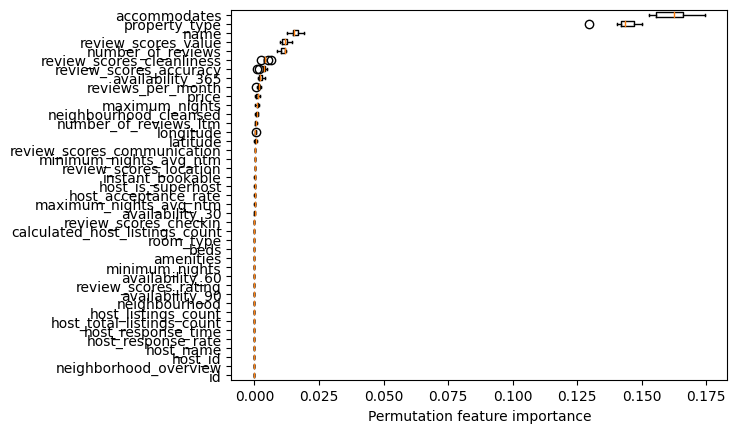

In [36]:
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
# feature_names = np.array(pipe_sklearn_histGB_opt.named_steps['columntransformer'].get_feature_names_out())
# coeffs = pipe_sklearn_histGB_opt.named_steps["logisticregression"].coef_.flatten()
# coeff_df = pd.DataFrame(coeffs, index=feature_names, columns=["Coefficient"])
# coeff_df_sorted = coeff_df.sort_values(by="Coefficient", ascending=False)
result = permutation_importance(pipe_sklearn_histGB_opt, X_train, y_train, n_repeats=10, random_state=123)
perm_sorted_idx = result.importances_mean.argsort()
plt.boxplot(
    result.importances[perm_sorted_idx].T,
    vert=False,
    labels=X_train.columns[perm_sorted_idx],
)
plt.xlabel('Permutation feature importance')
plt.show()

In [22]:
# import seaborn as sns

# feature_importances = pipe_sklearn_histGB_opt.named_steps["dt"].feature_importances_

# # Sort the feature importances from greatest to least using the sorted indices
# sorted_indices = feature_importances.argsort()[::-1]
# sorted_feature_names = tree_model.named_steps['ct'].get_feature_names_out()[sorted_indices]
# sorted_importances = feature_importances[sorted_indices]

# # # Create a bar plot of the feature importances
# sns.set(rc={'figure.figsize':(11.7,30)})
# sns.barplot(x=sorted_importances, y=sorted_feature_names)

In [23]:
# Given test_r2, pipe_rf_opt provides the best prediction
pipe_sklearn_histGB_opt.fit(X_train, y_train)
y_preds = pd.DataFrame(pipe_sklearn_histGB_opt.predict(test_df).T, columns=['monthly_revenue'])
ids = pd.DataFrame(test_df["id"], columns=['id'])

df = pd.concat([ids, y_preds], axis=1) 
# df.head()
df.info()
df.to_csv('submission.csv',index=False)
print('Generated Submission file')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1339 entries, 0 to 1338
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               1339 non-null   int64  
 1   monthly_revenue  1339 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 21.0 KB
Generated Submission file
